In [4]:
%config IPCompleter.greedy=True

In [5]:
import csv
import pandas as pd
import dateutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import datetime
from scipy.integrate import simps
from numpy import trapz
from scipy.optimize import curve_fit

## Reading the crowdfuning project data

In [ ]:
pdf = pd.DataFrame.from_csv('crowdfunding.data.10.17.csv')
pdf = pdf.drop_duplicates('Project Id').reset_index()

## Getting successful projects

In [215]:
newpdf = pdf[pdf['Goal'] <= pdf['Pledged']]
sids = newpdf['Project Id'].tolist()
#newpdf

## Reading twitter data

In [216]:
tdf = pd.DataFrame.from_csv('twitter_data_new.csv')
tdf = tdf.reset_index()

C:\Users\Salman Ahmed\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Filter the twitter data to get twitter data for successful projects

In [217]:
df = tdf[tdf['project id'].isin(sids)].reset_index()

## Convert date field to data object and filter out invalid date objects

In [218]:
'''Convert date string to date object'''
df['date']= pd.to_datetime(df['date'], errors='coerce')

'''cleaning the unknown format string dates'''
idx = df[df['date'].isnull()].index
df = df.drop(df.index[idx])

'''Sorting the data based on date'''
df = df.sort_values('date')

In [155]:
# store project ids for future use
pids = df['project id'].unique()

In [251]:
df['project id'].nunique()

6138

## Group the social data by project ids

In [219]:
groups = df.groupby('project id')

## Calculate the exposure curve for each project and average it to get the average exposure curve

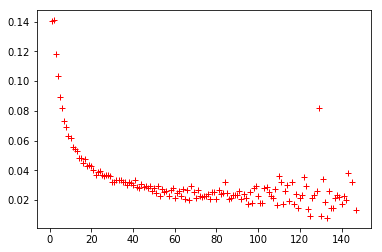

In [222]:
Prob = dict()
Freq = dict()

#m = 0
for g, main_gdf in groups:
    #if m > 10:
    #    break
    #m += 1
    
    #group = groups.get_group(721748605)
    total_population = np.rint(main_gdf['username'].nunique() * 2).astype(int)
    #print(total_population)
    
    if total_population > 300:
        continue

    week_group = main_gdf.groupby([pd.Grouper(key='date', freq='D')])

    if len(week_group) < 3:
        continue
        
    #We assume that the uses of first week is infected, so I(k) at t = 1 equals the total number of unique users in week 1
    infected_set = set()
    i = 0
    #K = []
    #P_k = []
    for g, gdf in week_group:
        if i == 0:
            i += 1
            #K.append(0)
            #P_k.append(0)
            Prob[0] = 0
            Freq[0] = 1
            infected_set.update(gdf['username'].unique())
            #print(infected_set)
            continue

        k = len(infected_set) #an user sees total len(infected_set) number of tweets, since we are treating the graph as clique
        E_k = total_population - len(infected_set)

        users_tweeted = set(gdf['username'].unique())
        newly_infected = users_tweeted - infected_set
        I_k = len(newly_infected)
        
        if I_k <= 0:
            continue

        infected_set.update(newly_infected)

        #K.append(k)
        #P_k.append(I_k/E_k)
        val = Prob.get(k, 0)
        Prob[k] = val + (I_k/E_k)
        count = Freq.get(k, 0)
        Freq[k] = count + 1
        #print(k, I_k/E_k)

#print(infected_set)

K = []
P_k = []
for key, value in sorted(Prob.items()):
    if key <= 0:
        continue
    K.append(key)
    P_k.append(value/Freq[key])
    #print(Freq[key])

plt.plot(K, P_k, 'r+')
plt.show()

## Infection probability function that fits with the average exposure curve

In [225]:
def infection_probability(k, delta, lamda, c):
    return delta * np.exp(-lamda * k) + c

popt, pcov = curve_fit(infection_probability, K, P_k)

## Fitting the average exposure with the infection probability function

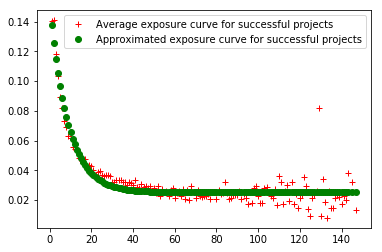

In [245]:
ydata = []
for v in K:
    ydata.append(infection_probability(v, popt[0], popt[1], popt[2]))
    
avg_curve, = plt.plot(K, P_k, 'r+')
approx_curve, = plt.plot(K, ydata, 'go')

plt.legend([avg_curve, approx_curve], ['Average exposure curve for successful projects', 'Approximated exposure curve for successful projects'])

#fig = plt.gcf()
#fig.set_size_inches(16, 14)
#fig.savefig('avg_exposure_success.jpg', dpi=200)

plt.show()

In [246]:
delta = popt[0]
lamda = popt[1]
c = popt[2]

In [241]:
# calcuate the actual infection from the twitter data
def actual_infection(day_group):
    
    Actual_Infection = dict()
    Actual_Freq = dict()

    Actual_Infection[0] = 0
    Actual_Freq[0] = 1
    
    infected_set = set()
    i = 1
    for g, gdf in day_group:
        
        if i > 10:
            break
        
        users_tweeted = set(gdf['username'])
        newly_infected = users_tweeted - infected_set
        
        Actual_Infection[i] = Actual_Infection.get(i-1, 0) + len(newly_infected)
        Actual_Freq[i] = Actual_Freq.get(i, 0) + 1
        
        infected_set.update(newly_infected)
        
        i += 1
        
    K = []
    P_k = []
    for key, value in sorted(Actual_Infection.items()):
        K.append(key)
        P_k.append(value)
        #print(Freq[key])    
    
    return K, P_k

In [247]:
# predict the infection using CC model
def cc_prediction(day_group, n, total_population, delta, lamda, c):
    
    result = [gg[1] for gg in list(day_group)[:1]]
    
    initial_infection = result[0]['username'].nunique()

    initial_susceptible = total_population

    I = []
    S = []   
    
    I.append(initial_infection)
    S.append(initial_susceptible)   
    
    for t in range(1, n):
        if S[t-1] == 0:
            
            I.append(I[t-1])
            S.append(S[t-1]) 
            continue
        
        infection_prob = infection_probability(I[t-1], delta, lamda, c)
        infection_rate = np.rint(infection_prob * S[t-1] * I[t-1]).astype(int)
        
        if infection_rate >= S[t-1]:
            new_infection = I[t-1] + S[t-1]
            susceptible_remain = 0
        else:
            new_infection = I[t-1] + infection_rate
            susceptible_remain = S[t-1]-infection_rate
        
        #print(I[t-1], infection_prob, infection_rate, new_infection, susceptible_remain)
        
        I.append(new_infection)
        S.append(susceptible_remain)
    
    return np.arange(n), I

In [248]:
image_count = 0

## Comparison of the actual and predicted (using CC model) infection 

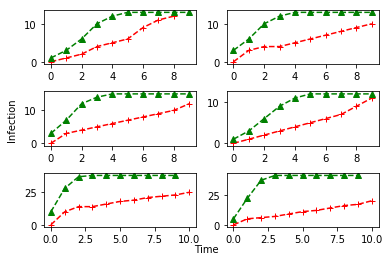

In [249]:
'''For actual infection curve'''

Actual_t = []
Prediction_t = []
Actual_It = []
Prediction_It = []

count = 0

while count < 6:
    
    taken_id = np.random.choice(pids, size = 1, replace=False)
    
    group = groups.get_group(taken_id[0])
    
    total_population = np.rint(group['username'].nunique() * 1).astype(int)
    #print(total_population)
    
    if total_population < 10 or total_population > 300:
        continue

    day_group = group.groupby([pd.Grouper(key='date', freq='D')])
    
    if len(day_group) < 3:# or len(day_group) > 8:
        continue

        
    t1, I_t1 = actual_infection(day_group)
    t2, I_t2 = cc_prediction(day_group, 10, total_population, delta, lamda, c)

    Actual_t.append(t1)
    Actual_It.append(I_t1)
    Prediction_t.append(t2)
    Prediction_It.append(I_t2)
    
    count += 1
    
    #actual, = plt.plot(K, P_k, 'r')
    #prediction, = plt.plot(T, I_t, 'g')
    #plt.legend([actual, prediction], ['Actual', 'Prediction'])
    #plt.plot(tmpK, tmpPk, 'g')
    #plt.axis([0, 6, 0, 20])
    #plt.show()

f, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2)
ax0.plot(Actual_t[0], Actual_It[0], '--r+')
ax0.plot(Prediction_t[0], Prediction_It[0], '--g^')

ax1.plot(Actual_t[1], Actual_It[1], '--r+')
ax1.plot(Prediction_t[1], Prediction_It[1], '--g^')

ax2.plot(Actual_t[2], Actual_It[2], '--r+')
ax2.plot(Prediction_t[2], Prediction_It[2], '--g^')

ax3.plot(Actual_t[3], Actual_It[3], '--r+')
ax3.plot(Prediction_t[3], Prediction_It[3], '--g^')

ax4.plot(Actual_t[4], Actual_It[4], '--r+')
ax4.plot(Prediction_t[4], Prediction_It[4], '--g^')

ax5.plot(Actual_t[5], Actual_It[5], '--r+')
ax5.plot(Prediction_t[5], Prediction_It[5], '--g^')

f.subplots_adjust(hspace=0.5)
#plt.suptitle('Main title')
#plt.suptitle('')
f.text(0.5, 0.04, 'Time', ha='center')
f.text(0.04, 0.5, 'Infection', va='center', rotation='vertical')
plt.savefig('actual_vs_prediction_success'+str(image_count)+'.png', bbox_inches='tight', dpi=100)
plt.show()
image_count += 1